# eda019
速度、角度予測による欠損値補間の要素検証

In [1]:
import os
import pandas as pd
import numpy as np
import ipynb_path
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
import plotly
import plotly.express as px
%matplotlib inline
pd.set_option('display.max_rows', 200)
from math import * 
import warnings
warnings.simplefilter('ignore')

In [2]:
def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [3]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=1000,
                            width=2000)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()

In [4]:
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [5]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [6]:
# lowpass filter

from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

order = 3
fs = 50.0
cutoff = 2.5

In [7]:
# Offset correction
# refarence https://github.com/J-ROCKET-BOY/SS-Fitting

def SS_fit(data) : 

    x = data[:,[0]]
    y = data[:,[1]]
    z = data[:,[2]]

    data_len = len(x)
    
    x2 = np.power(x,2)
    y2 = np.power(y,2)
    z2 = np.power(z,2)

    r1 = -x*(x2+y2+z2)
    r2= -y*(x2+y2+z2)
    r3 = -z*(x2+y2+z2)
    r4 = -(x2+y2+z2)

    left = np.array([[np.sum(x2),np.sum(x*y),np.sum(x*z),np.sum(x)],
                     [np.sum(x*y),np.sum(y2),np.sum(y*z),np.sum(y)],
                     [np.sum(x*z),np.sum(y*z),np.sum(z2),np.sum(z)],
                     [np.sum(x), np.sum(y), np.sum(z), data_len]])
    
    right = np.array([np.sum(r1),
                      np.sum(r2),
                      np.sum(r3),
                      np.sum(r4)])
    
    si = np.dot(np.linalg.inv(left),right)

    x0 = (-1/2)* si[0]
    y0 = (-1/2)* si[1]
    z0 = (-1/2)* si[2]
    
    return np.array([x0,y0,z0])

In [8]:
# Vincenty's formulae
# refarence https://qiita.com/r-fuji/items/99ca549b963cedc106ab

def vincenty_inverse(lat1, lon1, lat2, lon2):

    # Not advanced
    if isclose(lat1, lat2) and isclose(lon1, lon2):
        return False
    
    # WGS84
    a = 6378137.0
    ƒ = 1 / 298.257223563
    b = (1 - ƒ) * a

    lat_1 = atan((1 - ƒ) * tan(radians(lat1)))
    lat_2 = atan((1 - ƒ) * tan(radians(lat2)))
    
    lon_diff = radians(lon2) - radians(lon1)
    λ = lon_diff

    for i in range(1000):
        sinλ = sin(λ)
        cosλ = cos(λ)
        sinσ = sqrt((cos(lat_2) * sinλ) ** 2 + (cos(lat_1) * sin(lat_2) - sin(lat_1) * cos(lat_2) * cosλ) ** 2)
        cosσ = sin(lat_1) * sin(lat_2) + cos(lat_1) * cos(lat_2) * cosλ
        σ = atan2(sinσ, cosσ)
        sinα = cos(lat_1) * cos(lat_2) * sinλ / sinσ
        cos2α = 1 - sinα ** 2
        cos2σm = cosσ - 2 * sin(lat_1) * sin(lat_2) / cos2α
        C = ƒ / 16 * cos2α * (4 + ƒ * (4 - 3 * cos2α))
        λʹ = λ
        λ = lon_diff + (1 - C) * ƒ * sinα * (σ + C * sinσ * (cos2σm + C * cosσ * (-1 + 2 * cos2σm ** 2)))
        
        if abs(λ - λʹ) <= 1e-12:
            break
    else:
        return None

    α = atan2(cos(lat_2) * sinλ, cos(lat_1) * sin(lat_2) - sin(lat_1) * cos(lat_2) * cosλ)

    if α < 0:
        α = α + pi * 2

    return degrees(α)

In [9]:
def calc3(row):
    deg = - degrees(atan2(-1*row['calc2'],row['calc1']))
    if deg < 0:
        deg += 360
    return deg 

In [10]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# データ読み込み

In [11]:
accel_train = pd.read_csv(INPUT + '/prep/gnss/train/UncalAccel.csv')
gyro_train = pd.read_csv(INPUT + '/prep/gnss/train/UncalGyro.csv')
mag_train = pd.read_csv(INPUT + '/prep/gnss/train/UncalMag.csv')
train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
ground_truth = pd.read_csv(INPUT + '/prep/ground_truth_train.csv')

ori_train = pd.read_csv(INPUT + '/prep/gnss/train/OrientationDeg.csv')

ground_truth = ground_truth.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
gt = ground_truth[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg_gt', 'lngDeg_gt', 'speedMps', 'courseDegree']].copy()
train = train.merge(ground_truth, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')

# coursedegreeと座標移動から算出したdegの比較

In [12]:
def calc_degree_by_gt(df):
    phones = df['phone'].unique()
    df['deg'] = np.nan
    
    for idx in range(len(df)-1):
        if df.at[idx, 'phone'] != df.at[idx+1, 'phone']:
            continue
            
        lat = df.at[idx, 'latDeg_gt']
        lng = df.at[idx, 'lngDeg_gt']
        lat_next = df.at[idx+1, 'latDeg_gt']
        lng_next = df.at[idx+1, 'lngDeg_gt']
        
        res = vincenty_inverse(lat, lng, lat_next, lng_next)
        if res:
            df.at[idx, 'deg'] = res
    
    return df

In [13]:
train = calc_degree_by_gt(train)

In [14]:
def viz(df, cols, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    cols_n = len(cols)
    phones = df['phone'].unique()
    
    for phone in phones:
        df_tmp = df[df['phone']==phone].copy()
        
        fig, axes = plt.subplots(figsize=(5*cols_n, 20), nrows=cols_n,sharex=True)
        for i,c in enumerate(cols):
            axes[i].plot(df_tmp['millisSinceGpsEpoch'], df_tmp[c], label=c)
            axes[i].legend(loc='upper right')
            axes[i].grid(color='g', linestyle=':', linewidth=0.3)
        fig.suptitle(phone, fontsize=16)
        fig.savefig(output_dir + '/' + phone + '.png')
        plt.close()

In [15]:
train

collectionName        phoneName  millisSinceGpsEpoch     latDeg  \
0       2020-05-14-US-MTV-1           Pixel4        1273529463442  37.423575   
1       2020-05-14-US-MTV-1           Pixel4        1273529464442  37.423578   
2       2020-05-14-US-MTV-1           Pixel4        1273529465442  37.423573   
3       2020-05-14-US-MTV-1           Pixel4        1273529466442  37.423583   
4       2020-05-14-US-MTV-1           Pixel4        1273529467442  37.423579   
...                     ...              ...                  ...        ...   
131337  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760315000  37.334460   
131338  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760316000  37.334472   
131339  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760317000  37.334491   
131340  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760318000  37.334495   
131341  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760319000  37.334485   

            lngDeg  heightAboveWgs84EllipsoidM_x  \
0      -122.094091                        -34.06   
1      -122.094101                        -33.29   
2      -122.094111                        -30.99   
3      -122.094121                        -32.83   
4      -122.094114                        -34.49   
...            ...                           ...   
131337 -121.899600                         -8.09   
131338 -121.899583                         -7.59   
131339 -121.899597                         -8.35   
131340 -121.899583                         -8.73   
131341 -121.899570                         -7.64   

                                      phone  latDeg_gt   lngDeg_gt  \
0                2020-05-14-US-MTV-1_Pixel4  37.423576 -122.094132   
1                2020-05-14-US-MTV-1_Pixel4  37.423576 -122.094132   
2                2020-05-14-US-MTV-1_Pixel4  37.423576 -122.094132   
3                2020-05-14-US-MTV-1_Pixel4  37.423576 -122.094132   
4                2020-05-14-US-MTV-1_Pixel4  37.423576 -122.094132   
...                                     ...        ...         ...   
131337  2021-04-29-US-SJC-2_SamsungS20Ultra  37.334475 -121.899613   
131338  2021-04-29-US-SJC-2_SamsungS20Ultra  37.334475 -121.899613   
131339  2021-04-29-US-SJC-2_SamsungS20Ultra  37.334475 -121.899613   
131340  2021-04-29-US-SJC-2_SamsungS20Ultra  37.334475 -121.899613   
131341  2021-04-29-US-SJC-2_SamsungS20Ultra  37.334475 -121.899613   

        heightAboveWgs84EllipsoidM_y  timeSinceFirstFixSeconds  hDop  vDop  \
0                              33.21                    551.44   1.1   0.0   
1                              33.21                    552.44   1.1   0.0   
2                              33.21                    553.44   1.1   0.0   
3                              33.20                    554.44   1.1   0.0   
4                              33.20                    555.44   1.1   0.0   
...                              ...                       ...   ...   ...   
131337                         56.62                   2632.00   1.1   0.0   
131338                         56.62                   2633.00   1.1   0.0   
131339                         56.62                   2634.00   0.9   0.0   
131340                         56.63                   2635.00   1.0   0.0   
131341                         56.64                   2636.00   1.1   0.0   

        speedMps  courseDegree         deg  
0            0.0          12.7         NaN  
1            0.0          12.7         NaN  
2            0.0          12.7         NaN  
3            0.0          12.7         NaN  
4            0.0          12.7         NaN  
...          ...           ...         ...  
131337       0.0          60.0         NaN  
131338       0.0          60.0         NaN  
131339       0.0          60.0  176.524924  
131340       0.0          60.0         NaN  
131341       0.0          60.0         NaN  

[131342 rows x 16 columns]

In [16]:
phones = train['phone'].unique()
output_dir = OUTPUT + '/calc_deg'
os.makedirs(output_dir, exist_ok=True)
for phone in phones:
    tmp = train[train['phone']==phone].copy()
    fig, axes = plt.subplots(figsize=(20, 5), nrows=1,sharex=True)
    axes.plot(tmp['millisSinceGpsEpoch'], tmp['courseDegree'], label='courseDegree')
    axes.plot(tmp['millisSinceGpsEpoch'], tmp['deg'], label='calc_deg')
    axes.legend(loc='upper right')
    axes.grid(color='g', linestyle=':', linewidth=0.3)
    fig.suptitle(phone, fontsize=16)
    fig.savefig(output_dir + '/' + phone + '.png')
    plt.close()

ほぼ一致

# speedMpsと座標から算出した結果比較

In [17]:
def calc_speed_by_gt(df):
    phones = df['phone'].unique()
    df['speed'] = np.nan
    
    for idx in range(len(df)-1):
        if df.at[idx, 'phone'] != df.at[idx+1, 'phone']:
            continue
            
        lat = df.at[idx, 'latDeg_gt']
        lng = df.at[idx, 'lngDeg_gt']
        lat_next = df.at[idx+1, 'latDeg_gt']
        lng_next = df.at[idx+1, 'lngDeg_gt']
        
        res = calc_haversine(lat, lng, lat_next, lng_next)
        if res:
            df.at[idx, 'speed'] = res
    
    return df    

In [18]:
train = calc_speed_by_gt(train)

In [19]:
phones = train['phone'].unique()
output_dir = OUTPUT + '/calc_speed'
os.makedirs(output_dir, exist_ok=True)
for phone in phones:
    tmp = train[train['phone']==phone].copy()
    fig, axes = plt.subplots(figsize=(20, 5), nrows=1,sharex=True)
    axes.plot(tmp['millisSinceGpsEpoch'], tmp['speedMps'], label='speedMps')
    axes.plot(tmp['millisSinceGpsEpoch'], tmp['speed'], label='calc_speed')
    axes.legend(loc='upper right')
    axes.grid(color='g', linestyle=':', linewidth=0.3)
    fig.suptitle(phone, fontsize=16)
    fig.savefig(output_dir + '/' + phone + '.png')
    plt.close()

# speedとdegから相対座標移動を算出

In [20]:
# 楕円体
ELLIPSOID_GRS80 = 1 # GRS80
ELLIPSOID_WGS84 = 2 # WGS84

# 楕円体別の長軸半径と扁平率
GEODETIC_DATUM = {
    ELLIPSOID_GRS80: [
        6378137.0,         # [GRS80]長軸半径
        1 / 298.257222101, # [GRS80]扁平率
    ],
    ELLIPSOID_WGS84: [
        6378137.0,         # [WGS84]長軸半径
        1 / 298.257223563, # [WGS84]扁平率
    ],
}

# 反復計算の上限回数
ITERATION_LIMIT = 1000

'''
Vincenty法(順解法)
始点の座標(緯度経度)と方位角と距離から、終点の座標と方位角を求める
:param lat: 緯度
:param lon: 経度
:param azimuth: 方位角
:param distance: 距離
:param ellipsoid: 楕円体
:return: 終点の座標、方位角
'''
def vincenty_direct(lat, lon, azimuth, distance, ellipsoid=None):

    # 計算時に必要な長軸半径(a)と扁平率(ƒ)を定数から取得し、短軸半径(b)を算出する
    # 楕円体が未指定の場合はGRS80の値を用いる
    a, ƒ = GEODETIC_DATUM.get(ellipsoid, GEODETIC_DATUM.get(ELLIPSOID_WGS84))
    b = (1 - ƒ) * a

    # ラジアンに変換する(距離以外)
    φ1 = radians(lat)
    λ1 = radians(lon)
    α1 = radians(azimuth)
    s = distance

    sinα1 = sin(α1)
    cosα1 = cos(α1)

    # 更成緯度(補助球上の緯度)
    U1 = atan((1 - ƒ) * tan(φ1))

    sinU1 = sin(U1)
    cosU1 = cos(U1)
    tanU1 = tan(U1)

    σ1 = atan2(tanU1, cosα1)
    sinα = cosU1 * sinα1
    cos2α = 1 - sinα ** 2
    u2 = cos2α * (a ** 2 - b ** 2) / (b ** 2)
    A = 1 + u2 / 16384 * (4096 + u2 * (-768 + u2 * (320 - 175 * u2)))
    B = u2 / 1024 * (256 + u2 * (-128 + u2 * (74 - 47 * u2)))

    # σをs/(b*A)で初期化
    σ = s / (b * A)

    # 以下の計算をσが収束するまで反復する
    # 地点によっては収束しないことがあり得るため、反復回数に上限を設ける
    for i in range(ITERATION_LIMIT):
        cos2σm = cos(2 * σ1 + σ)
        sinσ = sin(σ)
        cosσ = cos(σ)
        Δσ = B * sinσ * (cos2σm + B / 4 * (cosσ * (-1 + 2 * cos2σm ** 2) - B / 6 * cos2σm * (-3 + 4 * sinσ ** 2) * (-3 + 4 * cos2σm ** 2)))
        σʹ = σ
        σ = s / (b * A) + Δσ

        # 偏差が.000000000001以下ならbreak
        if abs(σ - σʹ) <= 1e-12:
            break
    else:
        # 計算が収束しなかった場合はNoneを返す
        return None

    # σが所望の精度まで収束したら以下の計算を行う
    x = sinU1 * sinσ - cosU1 * cosσ * cosα1
    φ2 = atan2(sinU1 * cosσ + cosU1 * sinσ * cosα1, (1 - ƒ) * sqrt(sinα ** 2 + x ** 2))
    λ = atan2(sinσ * sinα1, cosU1 * cosσ - sinU1 * sinσ * cosα1)
    C = ƒ / 16 * cos2α * (4 + ƒ * (4 - 3 * cos2α))
    L = λ - (1 - C) * ƒ * sinα * (σ + C * sinσ * (cos2σm + C * cosσ * (-1 + 2 * cos2σm ** 2)))
    λ2 = L + λ1

    α2 = atan2(sinα, -x) + pi

    return {
        'lat': degrees(φ2),     # 緯度
        'lon': degrees(λ2),     # 経度
        'azimuth': degrees(α2), # 方位角
    }

In [21]:
def calc_next_coordinate(df):
    phones = df['phone'].unique()
    df['lat_next'] = np.nan
    df['lng_next'] = np.nan
    
    for idx in range(len(df)-1):
        if df.at[idx, 'phone'] != df.at[idx+1, 'phone']:
            continue
            
        lat = df.at[idx, 'latDeg_gt']
        lng = df.at[idx, 'lngDeg_gt']
        deg = df.at[idx, 'deg']
        speed = df.at[idx, 'speed']
        
        res = vincenty_direct(lat, lng, deg, speed)
        if res:
            df.at[idx, 'lat_next'] = res['lat']
            df.at[idx, 'lng_next'] = res['lon']
        
    return df    

In [22]:
train = calc_next_coordinate(train)

In [23]:
for idx in range(len(train)):
    a = idx

In [24]:
a

131341

In [25]:
def calc_prev_coordinate(df):
    phones = df['phone'].unique()
    df['lat_prev'] = np.nan
    df['lng_prev'] = np.nan
    
    for idx in range(len(df)):
        if idx == 0:
            continue
        if df.at[idx, 'phone'] != df.at[idx-1, 'phone']:
            continue
            
        lat = df.at[idx, 'latDeg_gt']
        lng = df.at[idx, 'lngDeg_gt']
        deg = df.at[idx, 'deg']
        speed = df.at[idx, 'speed']
        
        if deg > 180:
            deg += 180
        else:
            deg -= 180
        
        res = vincenty_direct(lat, lng, deg, speed)
        if res:
            df.at[idx, 'lat_prev'] = res['lat']
            df.at[idx, 'lng_prev'] = res['lon']
        
    return df   

In [26]:
train = calc_prev_coordinate(train)

In [28]:
collections = train['collectionName'].unique()

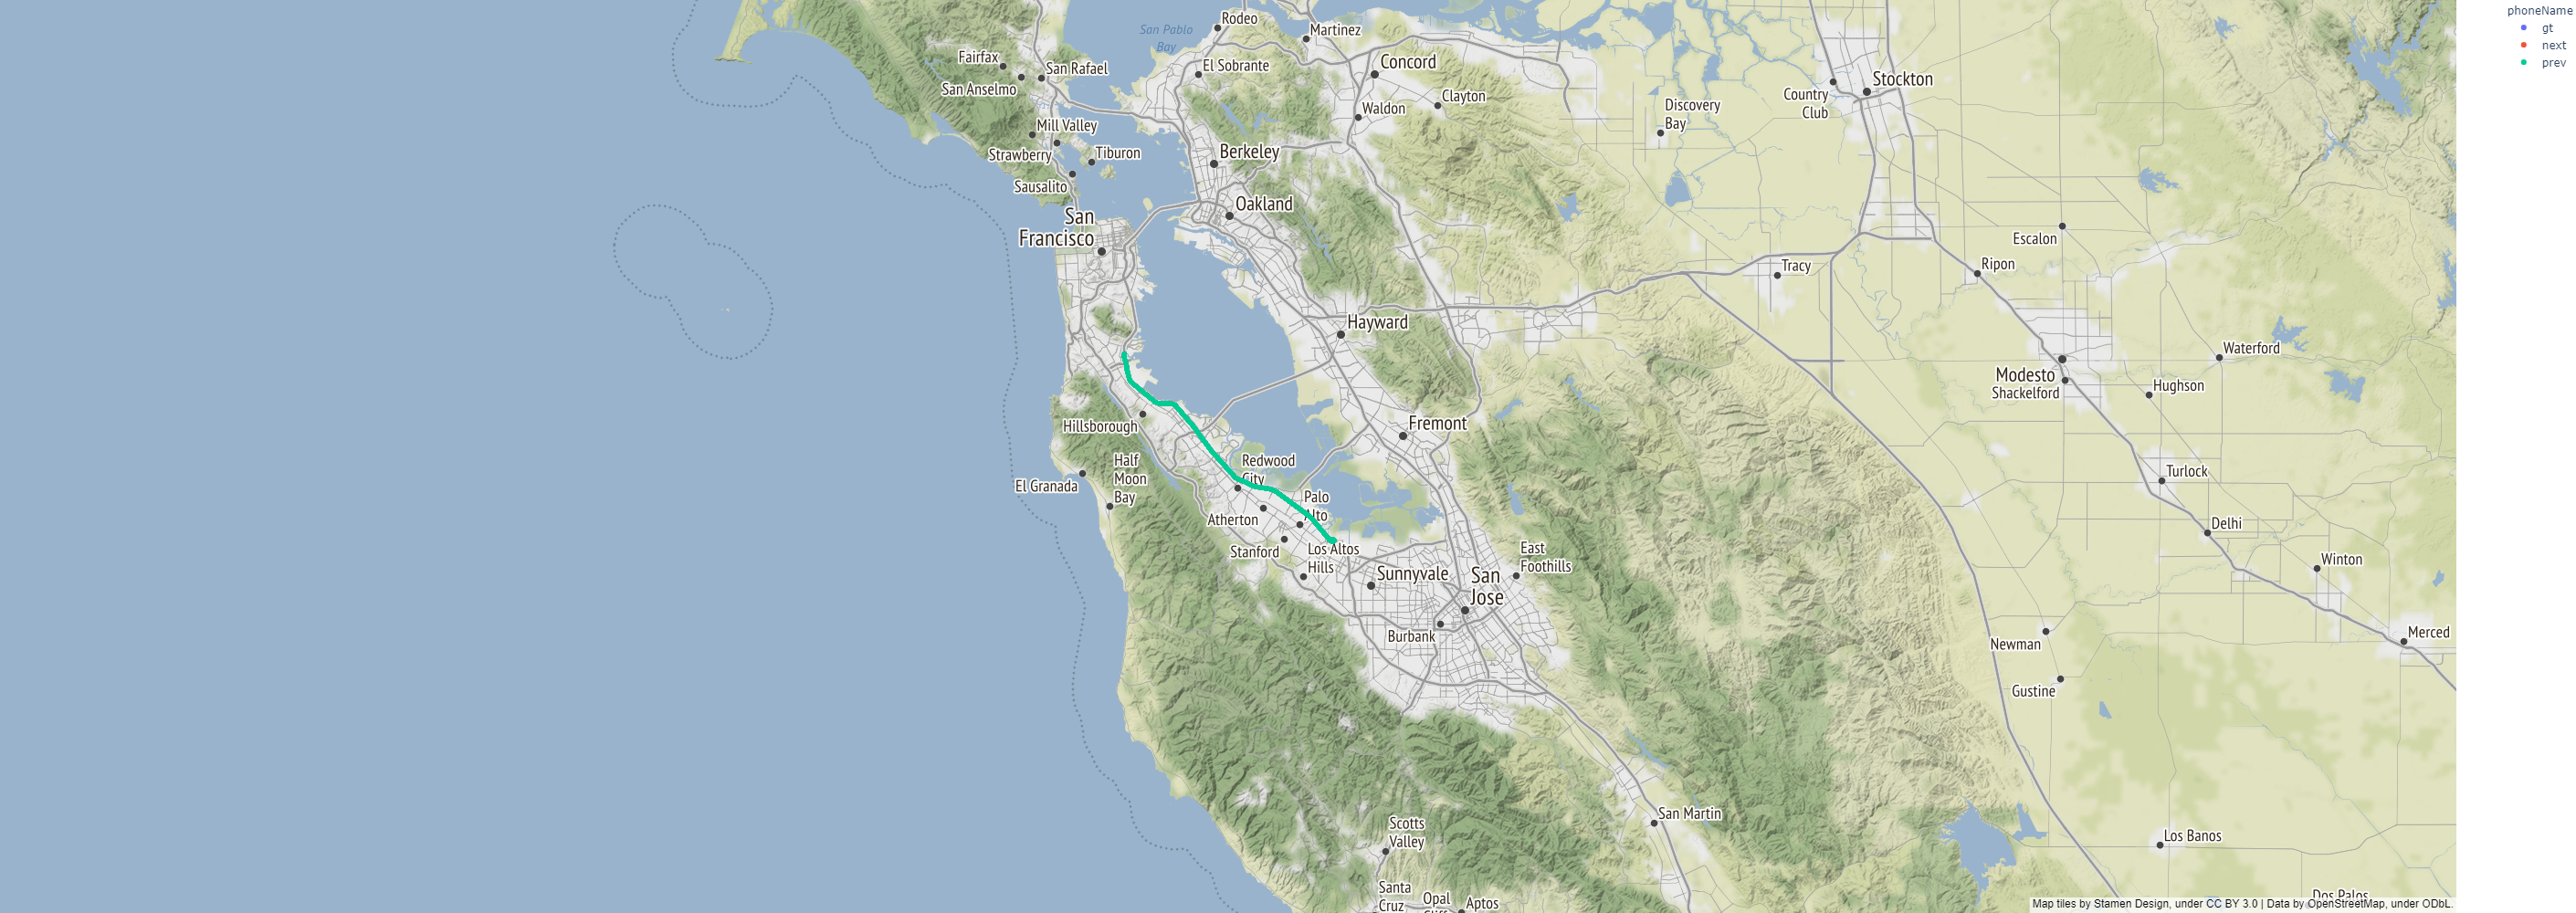

In [29]:
tmp1 = train[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg_gt', 'lngDeg_gt']].copy()
tmp2 = train[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'lat_next', 'lng_next']].copy()
tmp3 = train[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'lat_prev', 'lng_prev']].copy()

tmp1.columns = ['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']
tmp2.columns = ['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']
tmp3.columns = ['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']

tmp1['phoneName'] = 'gt'
tmp2['phoneName'] = 'next'
tmp3['phoneName'] = 'prev'

tmp = pd.concat([tmp1, tmp2, tmp3])

visualize_collection(tmp, collections[0])

一致一致